In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import abtem
abtem.config.set({'local_diagnostics.progress_bar': False});

# Wave functions
The multislice algorithm works by propagating the $xy$ part of the wave function (defined as $\phi$ in the [appendix](appendix/multislice_derivation.ipynb)) through the electrostatic potential. To initiate this process, we need to assume the initial conditions for the wave function, i.e. the wave function describing the electron beam formed by the electron optics before the sample.

abTEM defines three types of wave functions:

* [`PlaneWave`](wave_functions:plane_wave): Simulate HRTEM, SAED or other imaging modes with plane wave illumination.
* [`Probe`](wave_functions:probe): Simulate CBED, STEM, 4D-STEM or other imaging modes with a converged electron beam.
* [`Waves`](wave_functions:waves): Defines any custom wave function. The `PlaneWave` and `Probe` can be turned into `Waves`.


```{seealso}
The PRISM `SMatrix` is not included in the list above. However, it can be used to achieve most of the goals of using the `Probe`. See our introduction to PRISM in abTEM.
```

(wave_functions:plane_wave)=
## Plane wave functions

We create a plane wave on a $256 \times 256$ grid with a lateral extent of $5\times 5$ $\mathrm{Å}^2$ and an energy of $300 \ \mathrm{keV}$.

In [2]:
plane_wave = abtem.PlaneWave(gpts=256, extent=5, energy=300e3)

The real-space sampling, or pixel size, is calculated by dividing the `extent` by the number of grid points (`gpts`). The properties related to the grid, i.e. the `extent`, `gpts` and `sampling` can be accessed as:

In [3]:
plane_wave.extent, plane_wave.gpts, plane_wave.sampling

((5.0, 5.0), (256, 256), (0.01953125, 0.01953125))

The grid is fully defined from just two of the three quantities listed above, hence, we may pick any combination of two to define the grid. 

The relativistic wavelength in Ångstrom, derived from the energy, is accessed as:

In [4]:
print(f'Wavelength: {plane_wave.wavelength:.4f} Å')

Wavelength: 0.0197 Å


```{note}
*abTEM* uses the same unit conventions as ASE, as defined in the `ase.units` module. Thus, electron volts (eV), Ångström (Å), and atomic mass units are defined as 1.0. The electrostatic potential is given in (eV / e). Angles in *abTEM* are for convenience given in milliradians (mrad).

```
We can turn the `PlaneWave` into the generic `Waves` by using `build`.

In [5]:
waves = plane_wave.build()

waves

--------------------------------------------------

type           label    coordinates
-------------  -------  ------------------
RealSpaceAxis  x [Å]    0.00 0.02 ... 4.98
RealSpaceAxis  y [Å]    0.00 0.02 ... 4.98

        bytes       shape       count     type
------  ----------  ----------  --------  -------------
array   512.00 kiB  (256, 256)  2 tasks   complex64
chunks  512.00 kiB  (256, 256)  1 chunks  numpy.ndarray

The output above is the standard "repr" for *abTEM* objects. (TODO: explain)

The `Waves` describe the wave function as a complex `dask` array accessed below:

In [6]:
waves.array

dask.array<_extract_measurement, shape=(256, 256), dtype=complex64, chunksize=(256, 256), chunktype=numpy.ndarray>

The `Waves` are computed using the `.compute` method, this turns the `dask` array into a `numpy` array. The plane wave is just an array of ones:

In [7]:
waves.compute()

waves.array

array([[1.+0.j, 1.+0.j, 1.+0.j, ..., 1.+0.j, 1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j, ..., 1.+0.j, 1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j, ..., 1.+0.j, 1.+0.j, 1.+0.j],
       ...,
       [1.+0.j, 1.+0.j, 1.+0.j, ..., 1.+0.j, 1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j, ..., 1.+0.j, 1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j, ..., 1.+0.j, 1.+0.j, 1.+0.j]],
      dtype=complex64)

```{note}
In the above, the plane wave was normalized to be one in every grid point, i.e. the intensity per area is constant when the grid is changed. This is not always the natural choice, see the [appendix](appendix/normalization.ipynb) for more information on wave function normalization in abTEM.
```

(wave_functions:probe)=
## Probe wave functions

In abTEM, a focused beam of electrons, or `Probe`, is defined in Fourier space as

$$
    \hat{\phi}(\vec{k}) = A(\vec{k}) \ \exp(-i \chi(\vec{k})) \quad ,
$$

where $A(k)$ is the aperture function, $\chi(\vec{k})$ is the phase error and $\vec{k} = (k_x, k_y)$ is the spatial frequency in $x$ and $y$, respectively. The real-space probe is just the Fourier transform

$$
    \phi(\vec{r}) = \mathcal{F} \hat{\phi}(\vec{r}) \quad ,
$$

where $\vec{r} = (x, y)$ is the real space coordinate in $x$ and $y$, respectively. The probe wave function is normalized such that its intensity sums to $1$ in Fourier space

$$
    \int \|\hat{\phi}\|^2 d\vec{k} = 1 \quad .
$$


```{seealso}
The contrast transfer function of the `Probe` is introduced here.
```

We create a probe with a `sampling` of $0.05 \ \mathrm{Å}$, an `extent` of $10\times 10$ $\mathrm{Å}^2$, an `energy` of $100 \ \mathrm{keV}$, a convergence semiangle (`semiangle_cutoff`) of $30 \ \mathrm{mrad}$ and a `defocus` of $35 \ \mathrm{Å}$. 

In [8]:
probe = abtem.Probe(sampling = 0.05, 
                    extent = 20, 
                    energy = 100e3, 
                    semiangle_cutoff = 30,
                    defocus = 50,
                   )

The `Probe` may also be turned into `Waves` using the `.build` method.

In [9]:
probe.build()

--------------------------------------------------

type           label    coordinates
-------------  -------  -------------------
RealSpaceAxis  x [Å]    0.00 0.05 ... 19.95
RealSpaceAxis  y [Å]    0.00 0.05 ... 19.95

        bytes     shape       count     type
------  --------  ----------  --------  -------------
array   1.22 MiB  (400, 400)  4 tasks   complex64
chunks  1.22 MiB  (400, 400)  1 chunks  numpy.ndarray

We show the intensity of the probe in Fourier and real space below (i.e. $\|\hat{\phi}\|^2$ and $\|\phi\|^2$), respectively.

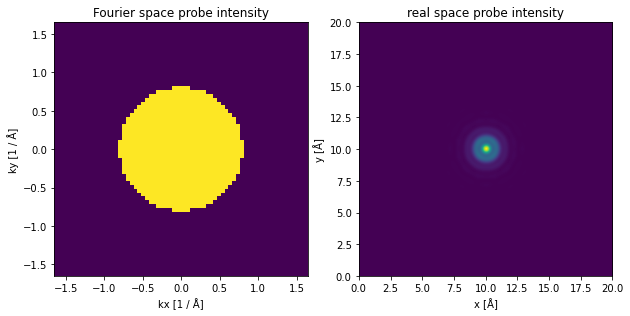

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

probe.build().diffraction_patterns(max_angle=60, parity='odd').show(ax=ax1, title='Fourier space probe intensity')
probe.build().intensity().show(ax=ax2, title='real space probe intensity');

````{note}
The axes convention for arrays representing a wave functions assigns the first axis to the $x$-axis and the second axis to the $y$-axis, and a larger array index implies a larger real-space coordinate. This is different from the convention often used for images. The correct way of displaying an array with `matplotplib` is given below.
    
```python
import matplotlib.pyplot as plt
image = waves.intensity().array
plt.imshow(image.T, extent=[0, waves.extent[0], 0, waves.extent[1]], origin='lower')
```     
````

## Measuring the wave function

In experiments, we cannot access the complex wave function, we have to measure its intensity. We just used the methods `intensity` and `diffraction_patterns`, these methods turn the wave function into a "measurement type", in this case `Images` and `DiffractionPatterns`, respectively. 

In [11]:
images = probe.build().intensity()

images

-------------------------------------------------------

type           label    coordinates
-------------  -------  -------------------
RealSpaceAxis  x [Å]    0.00 0.05 ... 19.95
RealSpaceAxis  y [Å]    0.00 0.05 ... 19.95

        bytes       shape       count     type
------  ----------  ----------  --------  -------------
array   625.00 kiB  (400, 400)  5 tasks   float32
chunks  625.00 kiB  (400, 400)  1 chunks  numpy.ndarray

In [12]:
diffraction_patterns = probe.build().diffraction_patterns()

diffraction_patterns

--------------------------------------------------------------------

type              label       coordinates
----------------  ----------  -------------------
FourierSpaceAxis  kx [1 / Å]  0.00 0.05 ... 13.25
FourierSpaceAxis  ky [1 / Å]  0.00 0.05 ... 13.25

        bytes       shape       count     type
------  ----------  ----------  --------  -------------
array   276.39 kiB  (266, 266)  5 tasks   float32
chunks  276.39 kiB  (266, 266)  1 chunks  numpy.ndarray

abTEM implements several more measurement types, each measurement type provides different methods for post-processing and analysis. See our introduction to "measurements".

As an example, we can use `interpolate_line_at_position` to create a `LineProfile` across the center of the probe intensity.

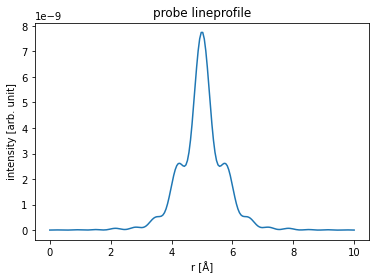

In [13]:
lineprofile = images.interpolate_line_at_position(center=(10, 10), angle=0, extent=10)

lineprofile.show(title='probe lineprofile');

## Wave function ensembles

In general, the `Waves` represent an ensemble of wave functions as a multidimensional array.  The last two dimensions of the `Waves` represent the spatial dimensions, these are the mandatory or *base* dimensions of the `Waves`. Any preceeding dimensions is an optional *ensemble* dimension. `abTEM` will automatically parallelize over the ensemble dimensions. See the [appendix](getting_started:appendix:ensembles) for more details on ensembles in `abTEM`.

As an example we create a `Probe` with a series of $5$ defocii ranging from $\mathrm{0}$ to $200 \ \mathrm{Å}$.

In [14]:
defocus_series = abtem.distributions.uniform(0, 200, 5)

probe_focal_series = abtem.Probe(sampling = 0.05, 
                                 extent = 20, 
                                 energy = 100e3, 
                                 semiangle_cutoff = 30,
                                 defocus = defocus_series,
                                )

waves_focal_series = probe_focal_series.build()

Inspecting the results, we see that the `Waves` have two base `RealSpaceAxis` and one ensemble `ParameterAxis`.

In [15]:
waves_focal_series

--------------------------------------------------

type           label    coordinates
-------------  -------  ------------------------
ParameterAxis  C10 [Å]  -0.00 -50.00 ... -200.00
RealSpaceAxis  x [Å]    0.00 0.05 ... 19.95
RealSpaceAxis  y [Å]    0.00 0.05 ... 19.95

        bytes     shape          count     type
------  --------  -------------  --------  -------------
array   6.10 MiB  (5, 400, 400)  5 tasks   complex64
chunks  6.10 MiB  (5, 400, 400)  1 chunks  numpy.ndarray

We show an exploded plot of the ensemble below. 

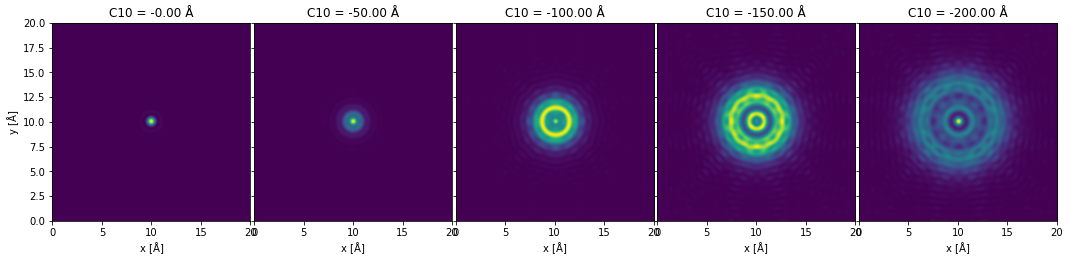

In [16]:
waves_focal_series.intensity().show(explode=True, figsize=(18, 5), image_grid_kwargs = {'axes_pad': .05});

````{tip}
If you have [Hyperspy](https://hyperspy.org/) installed, you can view the ensemble interactively by converting the `Images` to a `hyperspy` signal and using the interactive viewer.
```python
waves_focal_series.intensity().to_hyperspy().plot()
```
*Note: This requires using a matplotlib backend that supports interactivity.*
````

The `Waves` can have any number of ensemble dimensions, for example, 

In [17]:
scan = abtem.GridScan(start=(0,0), end=(20,20), gpts=200)

waves_scanned = probe_focal_series.build(scan=scan)

waves_scanned

/Users/jacobmadsen/PycharmProjects/abTEM_dask/abtem/waves/waves.py:746: PerformanceWarning: Increasing number of chunks by factor of 40
  array = da.blockwise(partial_build,


--------------------------------------------------

type           label    coordinates
-------------  -------  ------------------------
ParameterAxis  C10 [Å]  -0.00 -50.00 ... -200.00
ScanAxis       x [Å]    0.00 0.10 ... 19.90
ScanAxis       y [Å]    0.00 0.10 ... 19.90
RealSpaceAxis  x [Å]    0.00 0.05 ... 19.95
RealSpaceAxis  y [Å]    0.00 0.05 ... 19.95

        bytes       shape                    count        type
------  ----------  -----------------------  -----------  -------------
array   238.42 GiB  (5, 200, 200, 400, 400)  4091 tasks   complex64
chunks  122.07 MiB  (5, 4, 5, 400, 400)      2000 chunks  numpy.ndarray

````{warning}
Be careful when adding ensemble dimensions without also applying a reduction operation (e.g. taking an ensemble mean or applying a detector). The above wave function ensemble would require $\sim240 \ \mathrm{GiB}$(!) of memory to store.

````